# NBA Research

The NBA style of play has changed dramatically since the birth of the league. 

In the 1950s and 1960s, teams played at a frenetic pace, relying very heavily on their star players, some logging a season average of over 48 minutes.

...

Moden playing styles rely heavily on high quality shots - free throws, layups and 3 pointers, and we are seeing teams rely more heavily on depth (the days of superstar players logging over 40 minutes are gone).

The role of the modern day point guard has also shifted immensely, taking on more responsibility to score and shoot the ball, seen less as a floor general. However, since the level of skill in the modern day NBA has increased greatly (emergence of the point forward, flow of talent from Europe and focus on developing shooting and dribbling skills), teams can rely on other positions to create scoring opportunities.

With game-level data for the past 3 years, in this notebook I will try to answer a couple of questions:

* Does shooting 3pts and FTs increase a teams chances of winning in the modern-day NBA?
* What style of play is seen by winning teams in the NBA?
* How are modern day points playing compared to other positions?

It is important to note that this study is done using data from NBA regular season games from 2019-2022. Therefore I will only be researching about current day trends.

That is to say that conclusions brought from this analysis apply to the modern day NBA and not necessarily to NBA history or basketball in general.

## Base Preprocessing

In [1]:
import plotly.express as px
import pandas as pd
from datetime import datetime
pd.set_option('display.max_columns', None)


In [2]:
# read data for the Team Class
raw_data = pd.read_csv('./data/nba_raw_data.csv')

C:\Users\SILVAFRA\AppData\Local\Temp\ipykernel_10720\2427590962.py:2: DtypeWarning: Columns (68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('./data/nba_raw_data.csv')


First we will exclude playoff data, since the playing style in playoff games can be different than in the regular season (according to conventional wisdom) and not all teams play in the playoffs.

* Regular Season 2020: October 22nd 2019 - August 14th 2020 
* Playoffs 2020: 15th of August - 11th October

* Regular Season 2021: December 22nd 2021 - May 16th 2021
* Playoffs 2021: 22nd of May - 20th July

* Regular Season 2022:  October 19th 2021 - April 10th 2022
* Playoffs 2022: April 12th 2022 - June 16th 2022

In [3]:
raw_data['game_date'] = pd.to_datetime(raw_data['game_date'], dayfirst=True)

In [4]:
raw_data = raw_data[~((raw_data['game_date'] >= datetime(2020,8,15)) & (raw_data['game_date'] <= datetime(2020, 10, 11)))]

In [5]:
raw_data = raw_data[~((raw_data['game_date'] >= datetime(2021,5,22)) & (raw_data['game_date'] <= datetime(2021, 7, 20)))]

we will also classify season by season to get better insights into winning by season

In [6]:
season_dic = {'2019-2020': (datetime(2019,10,22), datetime(2020,8,14)), '2020-2021': (datetime(2020,12,22), datetime(2021, 5, 16)), '2021-2022': (datetime(2021,10,19), datetime(2022, 4, 10))}


def classify_season(game_date: datetime, season_dic: dict = season_dic):
    '''
    Function to classify season by date
    '''

    if game_date < season_dic['2019-2020'][1]:
        return '2019-2020'

    elif game_date < season_dic['2020-2021'][1]:
        return '2020-2021'

    else:
        return '2021-2022'

raw_data['season'] = raw_data['game_date'].apply(lambda d: classify_season(d))

While investigating the data, some of the entries where duplicated across fields, therefore we will first drop all duplicates from the data

In [7]:
len(raw_data[raw_data[['game_id', 'player_id']].duplicated(keep = False)])

50104

In [8]:
# have only the same player and game id once (sometimes duplicated)

raw_data = raw_data.drop_duplicates(subset = ['game_id', 'player_id'])

Very little null values. For the first set of questions, there are no null values in the relevant columns. For now, no treatment on null values has to be done

### Get Game Data

To answer the first question, I will need to aggregate the data to the game level.

For that I will create a separate module with a Team class to process the data to the game level.

In [9]:
import modules.team_data as td

In [10]:
team = td.Team(raw_data = raw_data)
team.get_winner()

In [11]:
# get 2 point field goals as well

team.data['fg2a'] = team.data['fga'] - team.data['fg3a']
team.data['fg2'] = team.data['fg'] - team.data['fg3']

In [12]:
print(team.data.columns)

Index(['game_id', 'game_date', 'OT', 'H_A', 'Team_Abbrev', 'Team_Score',
       'Team_pace', 'Team_efg_pct', 'Team_tov_pct', 'Team_orb_pct',
       'Team_ft_rate', 'Team_off_rtg', 'Inactives', 'Opponent_Abbrev',
       'Opponent_Score', 'Opponent_pace', 'Opponent_efg_pct',
       'Opponent_tov_pct', 'Opponent_orb_pct', 'Opponent_ft_rate',
       'Opponent_off_rtg', 'player', 'player_id', 'starter', 'mp', 'fg', 'fga',
       'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'plus_minus',
       'did_not_play', 'is_inactive', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct',
       'fta_per_fga_pct', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct',
       'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'off_rtg', 'def_rtg', 'bpm',
       'season', 'minutes', 'double_double', 'triple_double', 'DKP', 'FDP',
       'SDP', 'DKP_per_minute', 'FDP_per_minute', 'SDP_per_minute',
       'pf_per_minute', 'ts', 'last_60_minutes_per_game_s

In [13]:
# get the relevant columns for team data

team_columns = ["game_date",
'season',
"OT",
"H_A",
"Team_Abbrev",
"Team_Score",
"Team_pace",
"Team_efg_pct",
"Team_tov_pct",
"Team_orb_pct",
"Team_ft_rate",
"Team_off_rtg",
"Inactives",
'Opponent_pace',
'Opponent_efg_pct',
'Opponent_tov_pct',
'Opponent_orb_pct',
'Opponent_ft_rate',
'Opponent_off_rtg',
'Win'
]

# aggregate player variables to game - team to get basic statistics

aggregator = {
    'fg': sum,
    'fga': sum,
    'fg2a': sum,
    'fg2': sum,
    'fg3': sum,
    'fg3a': sum,
    'ft': sum,
    'fta': sum,
    'orb': sum,
    'drb': sum,
    'trb': sum,
    'ast': sum,
    'stl': sum,
    'blk': sum,
    'tov': sum,
    'pf': sum
}

In [14]:
# get game data
team.get_game_data(game_id = 'game_id', groupby_columns = team_columns, aggregator = aggregator)


In [15]:
team.game_data.head()

,game_id,game_date,season,OT,H_A,Team_Abbrev,Team_Score,Team_pace,Team_efg_pct,Team_tov_pct,Team_orb_pct,Team_ft_rate,Team_off_rtg,Inactives,Opponent_pace,Opponent_efg_pct,Opponent_tov_pct,Opponent_orb_pct,Opponent_ft_rate,Opponent_off_rtg,Win,fg,fga,fg2a,fg2,fg3,fg3a,ft,fta,orb,drb,trb,ast,stl,blk,tov,pf
0,201910220LAC,2019-10-22,2019-2020,0,A,LAL,102,95.3,0.512,12.9,20.9,0.176,107.0,"DeMarcus Cousins, Talen Horton-Tucker, Kyle Ku...",95.3,0.586,13.3,25.6,0.210,117.5,0,37,85,52,24,13,33,15,21,9,32,41,20,4,7,14,24
1,201910220LAC,2019-10-22,2019-2020,0,H,LAC,112,95.3,0.586,13.3,25.6,0.210,117.5,"Amir Coffey, Paul George, Rodney McGruder, Der...",95.3,0.512,12.9,20.9,0.176,107.0,1,42,81,50,31,11,31,17,24,11,34,45,24,8,5,14,25
2,201910220TOR,2019-10-22,2019-2020,1,A,NOP,122,102.2,0.515,14.6,28.1,0.167,108.1,"Zylan Cheatham, Josh Gray, Darius Miller, Zion...",102.2,0.476,11.8,30.2,0.311,115.2,0,43,102,57,24,19,45,17,20,16,37,53,30,4,9,19,34
3,201910220TOR,2019-10-22,2019-2020,1,H,TOR,130,102.2,0.476,11.8,30.2,0.311,115.2,"Oshae Brissett, Rondae Hollis-Jefferson, Patri...",102.2,0.515,14.6,28.1,0.167,108.1,1,42,103,63,28,14,40,32,38,16,41,57,23,7,3,16,24
4,201910230BRK,2019-10-23,2019-2020,1,A,MIN,127,105.2,0.486,9.8,24.0,0.204,109.3,"Keita Bates-Diop, Jordan McLaughlin, Jaylen No...",105.2,0.550,12.5,20.0,0.149,108.5,1,46,108,65,33,13,43,22,28,12,40,52,23,9,4,13,22


## Does shooting 3pts and FTs increase a teams probability of winning a game?

To answer the question, we can use simple box plot diagrams and analyze the following variables:

* 3pt attempts
* 3pt conversion
* FT attempts
* FT conversion

I will also segregate the variables between the winning and losing team to get a grasp of the difference between the style of play of the winning team and the losing team.

For the visualizations, I will use the plotly library

In [16]:
# get 2 point field goals as well
team.game_data['fg2_pct'] = team.get_conversion_variable(makes = 'fg2', attempts = 'fg2a')

# get variables to analyze
team.game_data['ft_pct'] = team.get_conversion_variable(makes = 'ft', attempts = 'fta')
team.game_data['fg3_pct'] = team.get_conversion_variable(makes = 'fg3', attempts = 'fg3a')
    
# get also fg percentage compare
team.game_data['fg_pct'] = team.get_conversion_variable(makes = 'fg', attempts = 'fga')

In [17]:
# identify id_vars
id_vars = ['game_id', 'Team_Abbrev', 'Win']

# get value_vars
value_vars_made = ['fg', 'fg2', 'fg3', 'ft']
value_vars_att = ['fga', 'fg2a', 'fg3a', 'fta']
value_vars_pct = ['fg_pct', 'fg2_pct', 'fg3_pct', 'ft_pct']

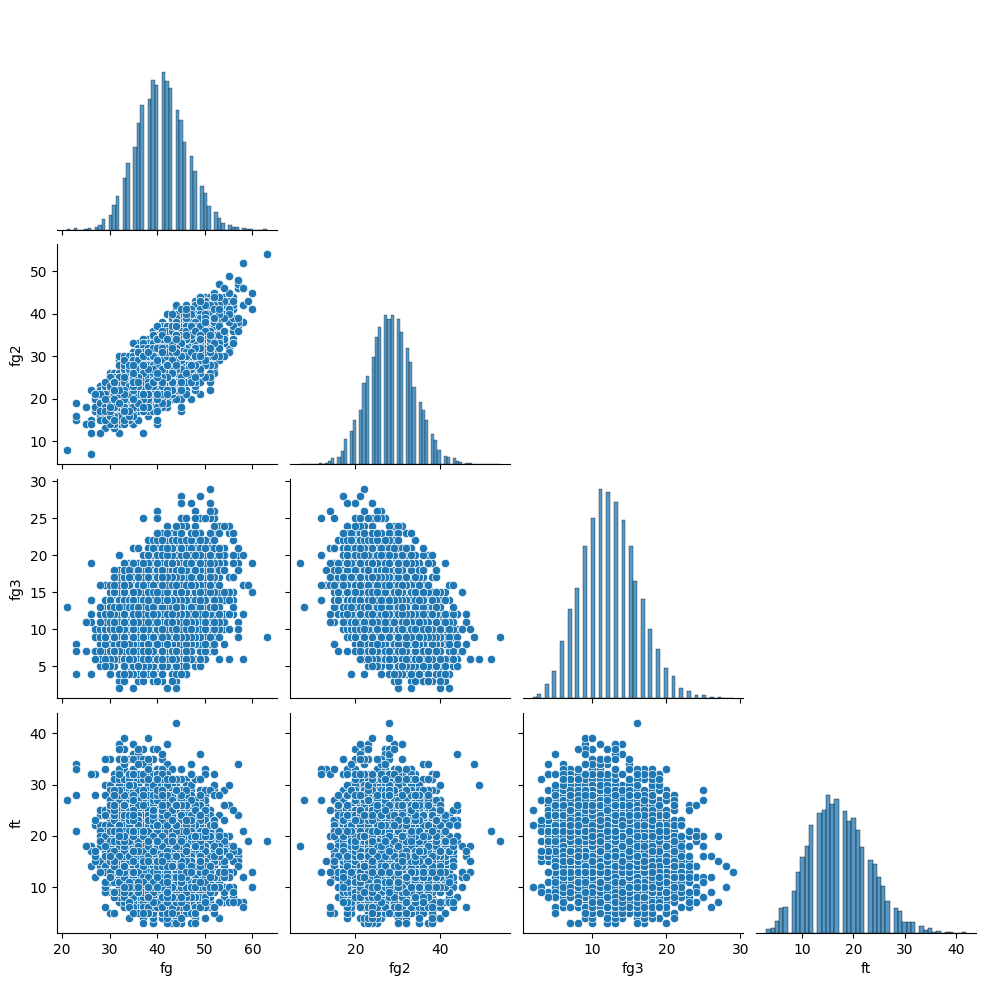

In [18]:
import seaborn as sns

sns.pairplot(team.game_data[value_vars_made], corner = True)

As expected, we see from the chart above that there are strong correlations between fgs made and fg2 (since fg2 are used to calculate fg) and fg3 (however weaker correlation). The variables from the graph above we see are normally distributed.

In [19]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': value_vars_made, 'var_name': 'shot_category'}
params_bx = {'y': 'value', 'x': 'shot_category', 'color': 'Win'}

In [20]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

As expected, winning teams make more shots than losing teams. The difference however is very similar across all categories, and we see that teams still rely more on 2 point field goals than on 3 point field goals.

However witth the graph above we see that 3 point shots represent around 25% of total shots (fg3 are included in the fg metric), while free throws are 40% of total shots (excluded in the fg metrics) 

To get a better indication of the style of play we can take a look at attempts, where we will understand more about a teams' playing style.

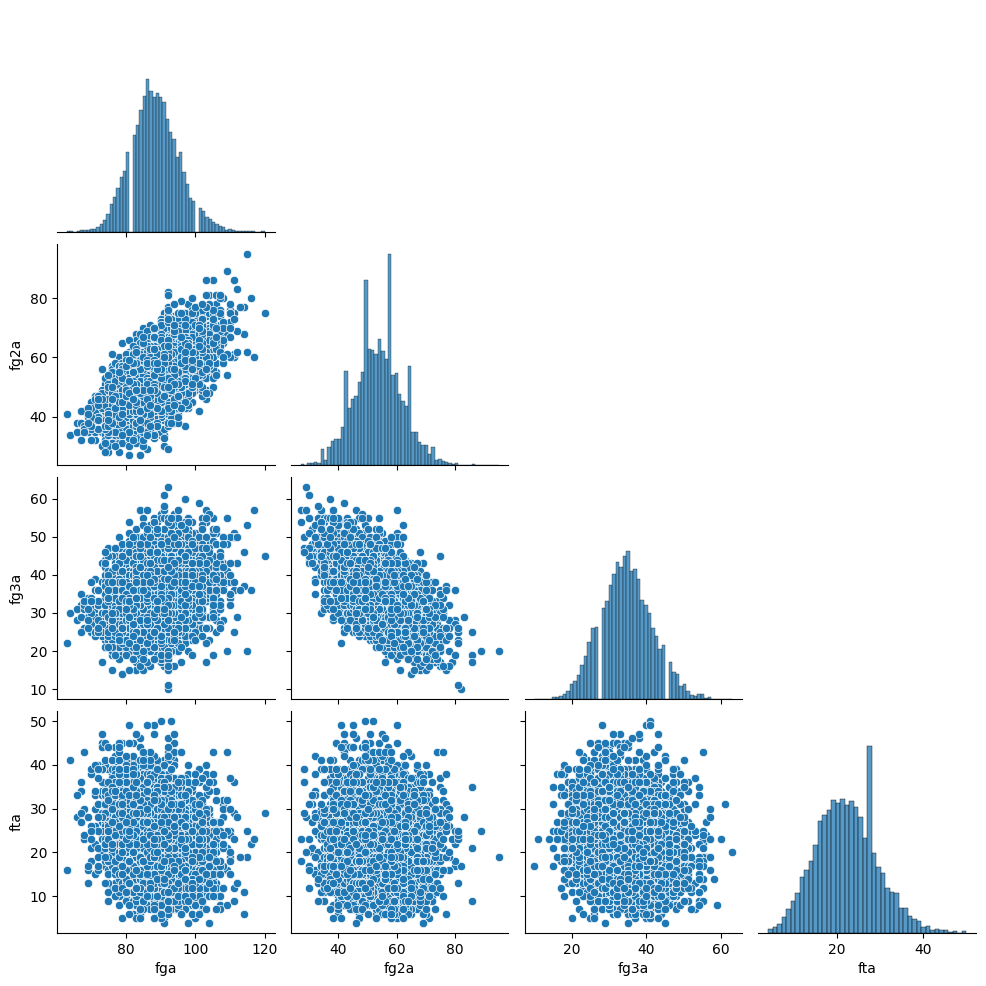

In [21]:
sns.pairplot(team.game_data[value_vars_att], corner = True)

In the charts above we see that all the variables have a normal distribution and are uncorrelated to each other. 

There is a slight correlation between fga and fg3a, since fga include fg3a (however less pronounced than expected). Therefore when building a model, fg3a and fga should be excluded based on the model they are fed into. 

In [22]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': value_vars_att, 'var_name': 'shot_category'}
params_bx = {'y': 'value', 'x': 'shot_category', 'color': 'Win'}

In [23]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group = params_group, params_bx = params_bx)

From the boxplots above, there is no significant difference in the values of the studied variables between winning and losing teams.

One slight surprise is that it seems that losing teams have a slightly higher median and sitribution of values for fga. Otherwise the variables are very similar for winning and losing teams.

In [24]:
params_scatter = {'y': 'fg3a', 'color': 'Win'}
px.scatter(data_frame=team.game_data, **params_scatter)

From the scatter plot above, we see very little difference between the 3 point field goals attempted between winning and losing teams, accentuating the findings from the boxplot. The distribution of attempted 3 pointers between winning teams and losing teams shows very little to no difference

In [25]:
params_scatter = {'y': 'fta', 'color': 'Win'}
px.scatter(data_frame=team.game_data, **params_scatter)

Free throws attempted we see potentially more of a difference, but very slight. We can reach a similar conclusion to the one reached for 3 point field goals

Lets analyze the differences between teams and their propensity to attempt 3 pointers

In [26]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': ['fg3a'], 'var_name': 'shot_category'}
params_bx = {'y': 'value', 'x': 'Team_Abbrev'}

In [27]:
team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

From the chart above we do see differences across teams. We see that all teams as a median attempt 30 3 pointers a game, however we see the Houston Rockets, Utah and Brookly rely heavily on 3 point field goals. Lets see how correlated 3 point attempts are with winning in the NBA standings.

In [28]:
season = td.TeamSeason(team.game_data)
season.get_season_stats()

In [29]:
season.season_data

,Team_Abbrev,season,games,wins,loses
0,ATL,2019-2020,67,20,47
1,ATL,2020-2021,71,40,31
2,ATL,2021-2022,83,44,39
3,BOS,2019-2020,72,48,24
4,BOS,2020-2021,71,36,35
...,...,...,...,...,...
85,UTA,2020-2021,71,51,20
86,UTA,2021-2022,83,50,33
87,WAS,2019-2020,72,25,47
88,WAS,2020-2021,71,33,38


In [ ]:
sns.pairplot(team.game_data[value_vars_pct], corner = True)

In [ ]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': value_vars_pct, 'var_name': 'shot_category'}
params_bx = {'y': 'value', 'x': 'shot_category', 'color': 'Win'}

In [ ]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

Again in conversion we see that there is no major difference between any of the conversion categories. In fact it seems that losing teams have a higher fg_pct and ft_pct than winning teams. This could happen due to other factors of the game (the winning team had more posessions during the game for example, which supports why we see a difference in shots made but no difference in conversion percentage).

From the analysis above, we see that in terms of simple shot distribution, there is no major difference between winning and losing teams. In the modern day NBA, it seems that all teams have adopted a playing style relying on 30 3pt field goal attempts, and no major differences in the conversion between winning and losing teams.

However in this analysis, we are analyzing the outcome of specific games. To analyze further the style of the best teams in the NBA, we could isolate the high ranking teams and analyze further theyre playing style.

## Other indicators for style of play

In [ ]:
other_vars = ['orb', 'ast', 'tov', 'stl', 'blk']

sns.pairplot(team.game_data[other_vars], corner = True)

In [ ]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': other_vars, 'var_name': 'box_score_stat'}
params_bx = {'y': 'value', 'x': 'box_score_stat', 'color': 'Win'}

In [ ]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

The variables above give us a better indication of how winning teams play.

Offensive rebounds are traditionally seen as a stat that could turn any game and key in the playoffs. However statistically it can represent three things: 1) a team missed a lot of shots and there were a lot of opportunities for an offensive rebound, 2) the team outhustled the other team and got a lot of rebounds, 3) both. To analyze better offensive rebounding, we need to take a look at offensive rebound rate

Assists seem like the highest indicator for a winning team. The median is 3 points higher than for losing teams and the outlier distribution is higher than for losing teams. This supports conventional basketball wisdom, since assists are usually seen to lead to higher quality shots and lead to better shot conversions.

The difference of turnovers, steals and blocks between losing and winning teams also supports conventional wisdom, but less significant than steals

In [ ]:
sns.pairplot(team.game_data[['fg', 'ast']], corner = True)

import numpy as np

print(np.corrcoef(x = team.game_data['fg'], y = team.game_data['ast']))

In [ ]:
# calculate assist ratio

team.game_data['ast_ratio'] = team.get_assist_ratio(data = team.game_data, ast = 'ast', fga = 'fga', fta = 'fta', to = 'tov')

In [ ]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': ['ast_ratio'], 'var_name': 'assist_ratio'}
params_bx = {'y': 'value', 'x': 'assist_ratio', 'color': 'Win'}

In [ ]:
team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

So for winning teams we see a less pronounced difference between assists and winning, but we still see a significant difference between assist ratio and winning a game.

Despite the lower difference, this statistic is more robust since conceptually, is less dependent on the amount of made field goals (since assists)

In [ ]:
sns.pairplot(team.game_data[['fg', 'ast_ratio']], corner = True)

print(np.corrcoef(x = team.game_data['fg'], y = team.game_data['ast_ratio']))

In [ ]:
vars_pct =  ['Team_efg_pct', 'Team_ft_rate']
vars_rates = ['Team_tov_pct', 'Team_orb_pct']

sns.pairplot(team.game_data[vars_pct + vars_rates], corner = True)

In [ ]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': vars_pct, 'var_name': 'advanced_stats'}
params_bx = {'y': 'value', 'x': 'advanced_stats', 'color': 'Win'}

In [ ]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

In [ ]:
scatter_params = {'y': 'Team_efg_pct', 'color': 'Win'}
px.scatter(data_frame=team.game_data, **scatter_params)

In [ ]:
sns.pairplot(team.game_data[['Team_efg_pct', 'ast_ratio']], corner = True)

print(np.corrcoef(x = team.game_data['Team_efg_pct'], y = team.game_data['ast_ratio']))

The effective field goal percentage has been one of the strongest indicators to differentiate between winning and losing teams. Winning teams have a median higher by 60 basis points corresponding to losing teams. This is also indicates that 3 pointers do have 

Free throw rate we also see a significant difference, but less pronounced, by 20 basis points.

In [ ]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': vars_rates, 'var_name': 'advanced_stats'}
params_bx = {'y': 'value', 'x': 'advanced_stats', 'color': 'Win'}

In [ ]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

In the turnover pct and orb pct we also see a difference a slight difference in both variables corresponding to traditional basketball wisdom. Teams committing less turnovers tend to win the game, and teams with a higher offensive rebound percentage tend to win the games as well.